In [64]:
import csv
import numpy as np
import utils
import hrr_utils
import time
import random

from scipy import spatial
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

N=100

def genX(verbs, indices):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))
    
    for m in range(len(indices)):
        pair = verbs[indices[m]]
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2

def closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present,rcond=5e-2), Past)

# should be closest to closed_train
def svd_closed_train(Past, Present, num_pc=20):
    past_u, past_s, past_v = np.linalg.svd(Past)
    pres_u, pres_s, pres_v = np.linalg.svd(Present)
    
    past_cidx = min(num_pc, past_u.shape[1])
    pres_cidx = min(num_pc, pres_u.shape[1])
    
    past_u = past_u[:, :past_cidx]
    past_s = np.diag(past_s[:past_cidx])
    past_v = past_v[:past_cidx, :]

    pres_u = pres_u[:, :pres_cidx]
    pres_s = np.diag(np.reciprocal(pres_s[:pres_cidx]))
    pres_v = pres_v[:pres_cidx, :]

    left = pres_u.dot(pres_s.dot(pres_v)).T
    right = past_u.dot(past_s.dot(past_v))
    
    rv = np.dot(left, right)
    return rv

def whitened_svd_closed_train(Past, Present, num_pc=20):
    past_u, past_s, past_v = np.linalg.svd(Past)
    pres_u, pres_s, pres_v = np.linalg.svd(Pres)
    
    past_cidx = min(num_pc, past_u.shape[1])
    pres_cidx = min(num_pc, pres_u.shape[1])
    past_u, past_v = past_u[:, :past_cidx], past_v[:past_cidx, :]
    pres_u, pres_v, = pres_u[:, :pres_cidx], pres_v[:pres_cidx, :]
    
    left = np.dot(pres_v, pres_u.T)
    right = np.dot(past_u, past_v.T)
    return np.dot(left, right)
    
def online_svd_closed_train(Past, Present):
    return None

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def round_to_tick(number):
    """Round a number to the closest half integer."""
    return round(number * 2) / 2

def graph(x, y1, y2, y1std, y2std, title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   
    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(np.arange(0, 1701, 400))
    
    start = round_to_tick(min(min(y1), min(y2)) - max(max(y1std),max(y2std)))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(y1std),max(y2std)))
    
    plt.yticks(np.arange(start-.5, end+.5, .5))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
    plt.title(title,fontsize=16)

    plt.xlim([0, 1700])

    plt.tight_layout()
# https://matplotlib.org/api/lines_api.html
def graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   

    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(np.arange(0, 1701, 400))
    start = round_to_tick(min(min(y1), min(y2)) - max(max(y1std),max(y2std)))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(y1std),max(y2std)))
    
    plt.yticks(np.arange(start-.5, end+.5, .5))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')
    plt.plot(x, y1irregular, ':', c='b', lw=2, label='Train')
    plt.plot(x, y2irregular, ':', c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
    plt.title(title,fontsize=16)

    plt.xlim([0, 1700])

    plt.tight_layout()

In [34]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)


regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

train_frac = 2/3.0

irregular_train_idx = int(train_frac*len(irreg_pres))
train_irreg = irregular[0:irregular_train_idx]

regular_train_idx = 1700 - len(train_irreg) 
train_reg = regular[0:regular_train_idx]

test_reg = regular[regular_train_idx:]
test_irreg = irregular[irregular_train_idx:]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

train_all = train_reg + train_irreg
test_all = test_reg + test_irreg

train_all_indices = [i for i in range(len(train_all))]
test_all_indices = [i for i in range(len(test_all))]
random.shuffle(train_all_indices)
random.shuffle(test_all_indices)

In [3]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_all,train_all_indices)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_all, test_all_indices)

In [65]:
x = np.arange(1, trainpres1.shape[0], 10)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])

y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]


for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    W = svd_closed_train(trainpast2[:k], trainpres1[:k], num_pc=20)
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N

('iter: ', 0)
('iter: ', 1)
('iter: ', 2)
('iter: ', 3)
('iter: ', 4)
('iter: ', 5)
('iter: ', 6)
('iter: ', 7)
('iter: ', 8)
('iter: ', 9)
('iter: ', 10)
('iter: ', 11)
('iter: ', 12)
('iter: ', 13)
('iter: ', 14)
('iter: ', 15)
('iter: ', 16)
('iter: ', 17)
('iter: ', 18)
('iter: ', 19)
('iter: ', 20)
('iter: ', 21)
('iter: ', 22)
('iter: ', 23)
('iter: ', 24)
('iter: ', 25)
('iter: ', 26)
('iter: ', 27)
('iter: ', 28)
('iter: ', 29)
('iter: ', 30)
('iter: ', 31)
('iter: ', 32)
('iter: ', 33)
('iter: ', 34)
('iter: ', 35)
('iter: ', 36)
('iter: ', 37)
('iter: ', 38)
('iter: ', 39)
('iter: ', 40)
('iter: ', 41)
('iter: ', 42)
('iter: ', 43)
('iter: ', 44)
('iter: ', 45)
('iter: ', 46)
('iter: ', 47)
('iter: ', 48)
('iter: ', 49)
('iter: ', 50)
('iter: ', 51)
('iter: ', 52)
('iter: ', 53)
('iter: ', 54)
('iter: ', 55)
('iter: ', 56)
('iter: ', 57)
('iter: ', 58)
('iter: ', 59)
('iter: ', 60)
('iter: ', 61)
('iter: ', 62)
('iter: ', 63)
('iter: ', 64)
('iter: ', 65)
('iter: ', 66)
('ite

/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: Mean of empty slice.


figures/regression-unregularized_closedform-trigram-N=100-W=1700-170516
figures/regression-separated-unregularized_closedform-trigram-N=100-W=1700-170516


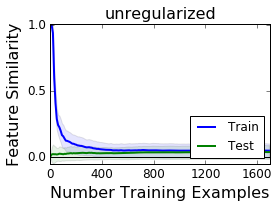

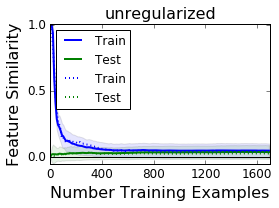

In [66]:
graph(x,y1,y2,y1std,y2std,title="unregularized", legend="lower right")

fname =  ('figures/regression-unregularized_closedform-trigram-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title="unregularized",legend="upper left")  

fname =  ('figures/regression-separated-unregularized_closedform-trigram-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)


In [ ]:
# broken oops
